In [1]:
%%capture
! python -m pip install verde
! pip install rioxarray

In [108]:
import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pyproj
from sklearn.model_selection import ShuffleSplit
import geopandas as gpd
import verde as vd
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from shapely import wkt
from shapely.geometry import Point, MultiPoint, box, Polygon
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import xarray as xr
import itertools
import rioxarray
import xarray as xr
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/kaggle/input/book-antiqua/BookAntiquaFont.ttf',
    name='Book Antiqua')

fe_bold = fm.FontEntry(
    fname='/kaggle/input/book-antiqua/Book Antiqua Bold.ttf',
    name='Book Antiqua B')

fm.fontManager.ttflist.insert(0, fe)
fm.fontManager.ttflist.insert(0, fe_bold)

matplotlib.rcParams['font.family'] = fe.name + ', ' + fe_bold.name
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['axes.unicode_minus'] = False  # use ASCII hyphen-minus instead of Unicode minus sign

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1024, 'height': 1024, 'count': 1, 'crs': CRS.from_epsg(32636), 'transform': Affine(40.0, 0.0, 434967.4583529874,
       0.0, -40.0, 3493582.1986368764), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'band'}
EPSG:32636
40.0
434967.4583529874
3493582.1986368764


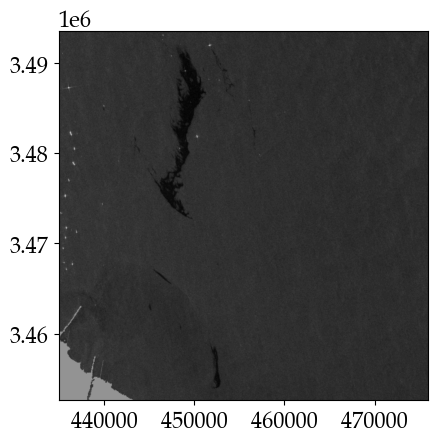

In [3]:
folder_path = '/kaggle/input/oilspill-image1/20141004T154824_Orb_Msk_Thm_Cal_Spk_db_40m_UTM_1024px.tif'
acquisition_date = '20141004T154824'

with rasterio.open(folder_path) as dataset:
    print(dataset.profile)

    proj = dataset.crs
    print(proj)

    xsize = dataset.width

    ysize = dataset.height

    transform = dataset.transform

    resolution = transform[0]
    print(resolution)

    ulx = transform[2]
    print(ulx)
    
    uly = transform[5]
    print(uly)

lrx = ulx + xsize * resolution
lry = uly - ysize * resolution

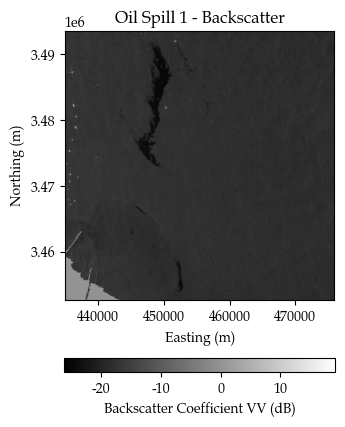

In [146]:
plt.figure(figsize=(3.5, 5))
plt.title("Oil Spill 1 - Backscatter", size=12)

# Get the data and transform from the image
data = image.read(1)
transform = image.transform

# Create an extent tuple from the transform and data shape
extent = rasterio.plot.plotting_extent(data, transform)

# Plot the image with extent and cmap
plt.imshow(data, extent=extent, cmap='gray')

# Add colorbar at the bottom with a padding of 0.2
cbar = plt.colorbar(label="Backscatter Coefficient VV (dB)", pad=0.15, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# Add x and y-axis labels with units
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.yticks(np.arange(3460000, 3500000, 10000))
plt.savefig('oil spill 1 Backscatter Image.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

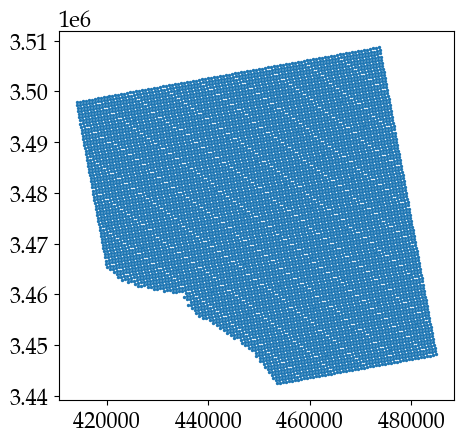

In [4]:
csv_path = r'/kaggle/input/wind-speed-csv/WindField.csv'
df = pd.read_csv(csv_path, skiprows=4, delimiter="\t")
# Convert the WKT format points to Shapely Point objects
df['geometry'] = df.iloc[:, 2].apply(wkt.loads)
# Create a GeoDataFrame from the Pandas dataframe
points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=proj)
# Plot the points on a map
ax = points_gdf.plot(markersize=2)
# Show the map
plt.show()

In [18]:
image_bounds = image.bounds
# print(image_bounds)
image_bb = box(*image_bounds)
# print(image_bb.wkt)
boundary_gdf = gpd.GeoDataFrame({"geometry":[image_bb]},crs=proj)

points_clip = gpd.clip(points_gdf, boundary_gdf)
print(points_clip.head())
# points_clip = points_gdf
# print(points_clip)

# ax = boundary_gdf.plot()
# Show the map
plt.show()

   org.esa.snap_geometry_26Feb2023T13.39.39 WindField:String  \
22                               ID00000022        wind_1017   
23                               ID00000023        wind_1018   
27                               ID00000027        wind_1021   
28                               ID00000028        wind_1022   
29                               ID00000029        wind_1023   

                                   geometry:Point  speed:Double  \
22   POINT (451700.4278349093 3452624.0049270308)           0.1   
23  POINT (452290.58779315895 3452731.3323878977)           6.0   
27   POINT (449229.78217498574 3452791.701762084)           3.2   
28   POINT (449819.7268792026 3452899.6004268927)           0.1   
29   POINT (450409.6588257134 3453007.5319926194)           2.1   

    heading:Double  dx:Double  dy:Double  ratio:Double  \
22       -1.000000        0.0        0.0           0.0   
23      349.308402        0.0       20.0           1.0   
27      349.292926        0.0       20

In [6]:
# Get X and Y coordinates of wind field points
x_wind = points_clip["geometry"].x
# print(x_wind)
y_wind = points_clip["geometry"].y
# print(y_wind)

outputBounds = [ulx,lrx,lry,uly]
print(outputBounds)

# Create list of XY coordinate pairs
coords_wind = [list(xy) for xy in zip(x_wind, y_wind)]
coords_wind_arr = np.array(coords_wind)

# get list of wind speed values
value_wind = list(points_clip.iloc[:,3])
value_wind_arr = np.array(value_wind)

[434967.4583529874, 475927.4583529874, 3452622.1986368764, 3493582.1986368764]


In [7]:
coords_wind_arr = np.moveaxis(coords_wind_arr,0, -1)
print(coords_wind_arr.shape)

(2, 4524)


In [8]:
train = coords_wind_arr, value_wind_arr
print(train)

(array([[ 451700.42783491,  452290.58779316,  449229.78217499, ...,
         471030.71949629,  471620.93740049,  472211.14295121],
       [3452624.00492703, 3452731.3323879 , 3452791.70176208, ...,
        3493306.12762562, 3493413.00230403, 3493519.91046061]]), array([0.1, 6. , 3.2, ..., 2.5, 0.1, 9.1]))


The returned train and test variables are tuples containing coordinates, data, and (optionally) weights arrays. Since we’re not using weights, the third element of the tuple will be None:

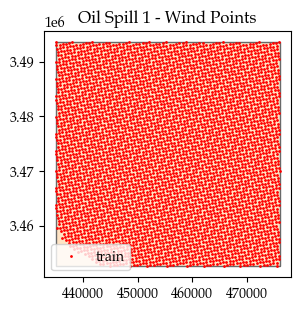

In [72]:
plt.figure(figsize=(3.2, 3.2))
ax = plt.axes()
ax.set_title("Oil Spill 1 - Wind Points", fontweight="bold", size=12)
boundary_gdf.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray', aspect=1)
ax.plot(train[0][0], train[0][1], "or", markersize=1, label="train")
ax.legend(fontsize=10)
# Set x and y ticks font size
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.offsetText.set_fontsize(10)
plt.xticks()
plt.yticks()
# ax.set_aspect("equal")
plt.savefig('oil spill 1 wind field points train only example.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

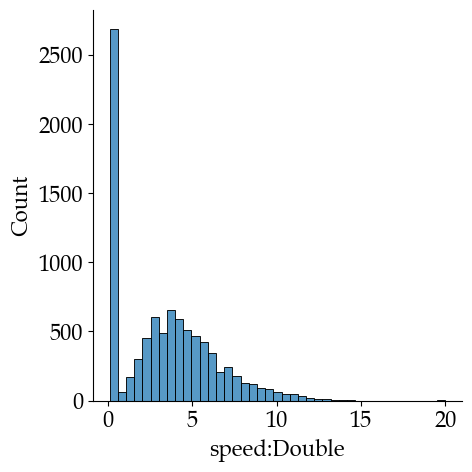

In [10]:
sns.displot(df['speed:Double'])

# Verde Spline

The Green’s functions based interpolations in Verde are all linear regressions under the hood. This means that we can use some of the same tactics from sklearn.model_selection to evaluate our interpolator’s performance. Once we have a quantified measure of the quality of a given fitted gridder, we can use it to tune the gridder’s parameters, like damping for a Spline (see Model Selection).

Verde provides adaptations of common scikit-learn tools to work better with spatial data.

In [11]:
dampings = [1e-2]
mindists = [5e3]

spline = vd.SplineCV(dampings=dampings, mindists=mindists, delayed=True)

In [12]:
spline.fit(coords_wind_arr, value_wind_arr)

print("Best damping:", spline.damping_)
print("Best mindist:", spline.mindist_)

Best damping: 0.01
Best mindist: 5000.0


In [13]:
grid = spline.grid(
    region=outputBounds,
    shape=(1024,1024),
    pixel_register=True,
    data_names='wind_speed',
)
print(grid)

<xarray.Dataset>
Dimensions:     (northing: 1024, easting: 1024)
Coordinates:
  * easting     (easting) float64 4.35e+05 4.35e+05 ... 4.759e+05 4.759e+05
  * northing    (northing) float64 3.453e+06 3.453e+06 ... 3.494e+06 3.494e+06
Data variables:
    wind_speed  (northing, easting) float64 2.773 2.777 2.782 ... 3.495 3.488
Attributes:
    metadata:  Generated by SplineCV(dampings=[0.01], delayed=True, mindists=...


In [ ]:
plt.figure(figsize=(3.6, 3.6))
ax = plt.axes()
ax.set_title("Oil Spill 1 - Wind Field Points", fontweight="bold", size=12)
boundary_gdf.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray', aspect=1)
ax.plot(train[0][0], train[0][1], "or", markersize=1, label="train")
ax.legend(fontsize=10)
# Set x and y ticks font size
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.offsetText.set_fontsize(10)
plt.xticks()
plt.yticks()
# ax.set_aspect("equal")
plt.savefig('oil spill 1 wind field points train only example.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

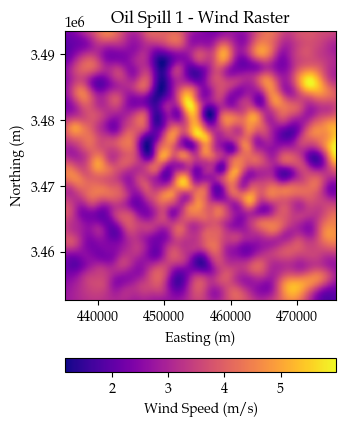

In [147]:
plt.figure(figsize=(3.5, 5))
ax = plt.axes()
ax.set_title("Oil Spill 1 - Wind Raster", size=12)
pc = grid.wind_speed.plot.pcolormesh(
    ax=ax,
    cmap="plasma",
    add_colorbar=False,
    add_labels=False,
)
cbar = plt.colorbar(pc, pad=0.15, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# Add x and y-axis labels with units
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar.set_label("Wind Speed (m/s)", fontsize=10)
# ax.plot(x_wind, y_wind, ".k", markersize=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.offsetText.set_fontsize(10)
ax.set_yticks(np.arange(3460000, 3500000, 10000))
# ax.set_aspect("equal")
plt.savefig('oil spill 1 wind field raster train only example.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

In [15]:
raster_name = fr'{acquisition_date}_40m_wind_speed_verde.tif'
ws = grid['wind_speed']
ws = ws.rio.set_spatial_dims(x_dim='easting',y_dim='northing')
print(ws.rio.crs)
ws.rio.write_crs(proj, inplace=True)
print(ws.rio.crs)
ws.rio.write_transform(transform, inplace=True)
print(ws.rio.transform)
ws.rio.to_raster(raster_path=raster_name)

None
EPSG:32636
<bound method XRasterBase.transform of <rioxarray.raster_array.RasterArray object at 0x7b8b78067bd0>>
